In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from sodapy import Socrata

from shapely.geometry import Point, Polygon
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

import mapclassify as mc
import scipy.ndimage as ndimage

from geopy import distance

In [5]:
#crime statistics from
#https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc
client = Socrata("data.cityofnewyork.us", None)
Results = client.get("uip8-fykc", limit=100000)
crime_df = pd.DataFrame.from_records(Results)

In [6]:
crime_df.ofns_desc.unique()

array(['SEX CRIMES', 'ROBBERY', 'DANGEROUS DRUGS', nan, 'GRAND LARCENY',
       'PETIT LARCENY', 'FELONY ASSAULT', 'ASSAULT 3 & RELATED OFFENSES',
       'MURDER & NON-NEGL. MANSLAUGHTE', 'BURGLARY',
       'CRIMINAL MISCHIEF & RELATED OF', 'RAPE', 'CRIMINAL TRESPASS',
       'MISCELLANEOUS PENAL LAW', 'OTHER OFFENSES RELATED TO THEF',
       'VEHICLE AND TRAFFIC LAWS', 'FOR OTHER AUTHORITIES',
       "BURGLAR'S TOOLS", 'OFFENSES AGAINST THE PERSON',
       'UNAUTHORIZED USE OF A VEHICLE', 'OTHER TRAFFIC INFRACTION',
       'OFF. AGNST PUB ORD SENSBLTY &', 'HOMICIDE-NEGLIGENT,UNCLASSIFIE',
       'NYS LAWS-UNCLASSIFIED FELONY', 'INTOXICATED & IMPAIRED DRIVING',
       'FORGERY', 'PROSTITUTION & RELATED OFFENSES',
       'OTHER STATE LAWS (NON PENAL LA', 'DANGEROUS WEAPONS',
       'GRAND LARCENY OF MOTOR VEHICLE', 'ANTICIPATORY OFFENSES',
       'KIDNAPPING & RELATED OFFENSES', 'THEFT-FRAUD',
       'POSSESSION OF STOLEN PROPERTY', 'OFFENSES AGAINST PUBLIC ADMINI',
       'OFFENSES INV

In [7]:
crime_df = crime_df.astype({'latitude': 'float64'})
crime_df = crime_df.astype({'longitude': 'float64'})

In [8]:
crime_geo_df = gpd.GeoDataFrame(
    crime_df, geometry=gpd.points_from_xy(crime_df.longitude, crime_df.latitude))

In [9]:
df = pd.read_csv('./AB_NYC_2019.csv')

In [10]:
df.shape

(48895, 16)

In [11]:
df.describe()

id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48895.000000       48895.000000       38843.000000   
mean         7.029962          23.274466           1.373221   
std         20.510550          44.550582           1.680442   
min          1.000000           0.000000           0.010000   
25%          1.000000           1.000000           0.190000   
50%          3.000000           5.000000           0.720000   
75%          5.000000          24.000000           2.020000   
max       1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365  
count                    48895.000000      48895.000000  
mean                         7.143982        112.781327  
std                         32.952519        131.622289  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          1.000000         45.000000  
75%                          2.000000        227.000000  
max                        327.000000        365.000000

In [12]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [13]:
df = df.drop(['id', 'name', 'host_id', 'host_name', 'last_review', 'neighbourhood_group', 'neighbourhood', 'room_type', 'reviews_per_month'], axis=1)

In [14]:
rent_geo_df = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

In [15]:
rent_geo_df

latitude  longitude  price  minimum_nights  number_of_reviews  \
0      40.64749  -73.97237    149               1                  9   
1      40.75362  -73.98377    225               1                 45   
2      40.80902  -73.94190    150               3                  0   
3      40.68514  -73.95976     89               1                270   
4      40.79851  -73.94399     80              10                  9   
...         ...        ...    ...             ...                ...   
48890  40.67853  -73.94995     70               2                  0   
48891  40.70184  -73.93317     40               4                  0   
48892  40.81475  -73.94867    115              10                  0   
48893  40.75751  -73.99112     55               1                  0   
48894  40.76404  -73.98933     90               7                  0   

       calculated_host_listings_count  availability_365  \
0                                   6               365   
1                                   2               355   
2                                   1               365   
3                                   1               194   
4                                   1                 0   
...                               ...               ...   
48890                               2                 9   
48891                               2                36   
48892                               1                27   
48893                               6                 2   
48894                               1                23   

                         geometry  
0      POINT (-73.97237 40.64749)  
1      POINT (-73.98377 40.75362)  
2      POINT (-73.94190 40.80902)  
3      POINT (-73.95976 40.68514)  
4      POINT (-73.94399 40.79851)  
...                           ...  
48890  POINT (-73.94995 40.67853)  
48891  POINT (-73.93317 40.70184)  
48892  POINT (-73.94867 40.81475)  
48893  POINT (-73.99112 40.75751)  
48894  POINT (-73.98933 40.76404)  

[48895 rows x 8 columns]

<AxesSubplot:>

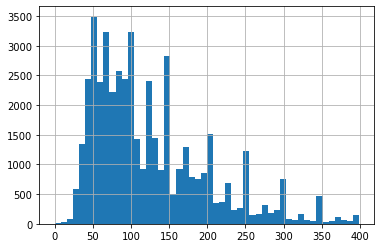

In [16]:
rent_geo_df[rent_geo_df.price < 400].price.hist(bins=50)

In [17]:
boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))

In [18]:
scheme_rent_price = mc.Quantiles(rent_geo_df['price'], k=10)

<GeoAxesSubplot:>

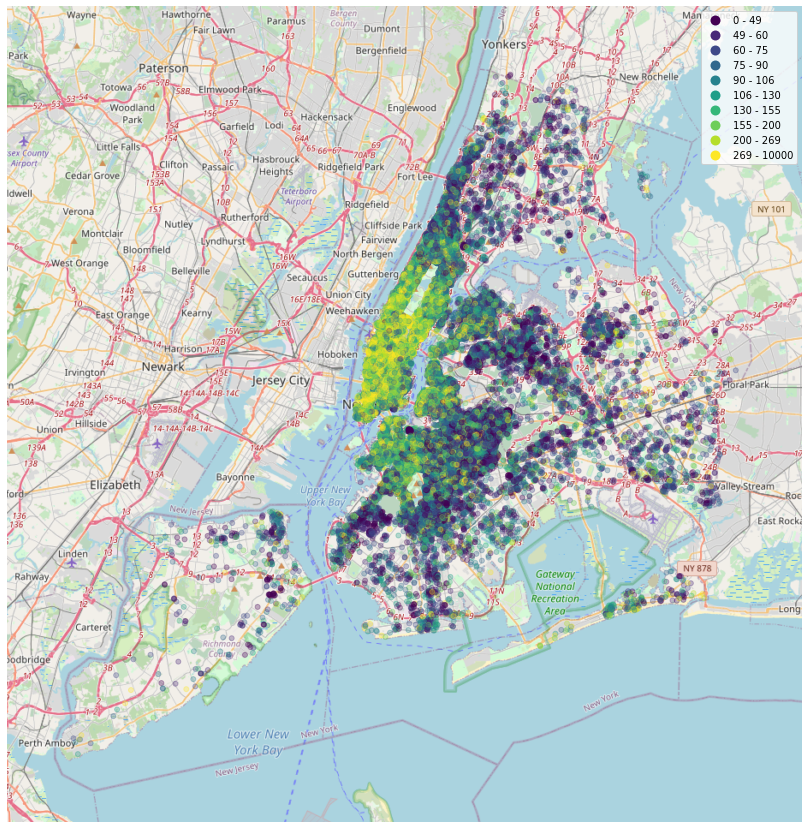

In [19]:
ax = gplt.webmap(boroughs, projection=gcrs.WebMercator(), figsize=(15,15))

gplt.pointplot(
    rent_geo_df,
    hue=rent_geo_df.price,
    ax = ax,
    alpha=0.3,
    scheme=scheme_rent_price,
    legend=True
)

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


<GeoAxesSubplot:>

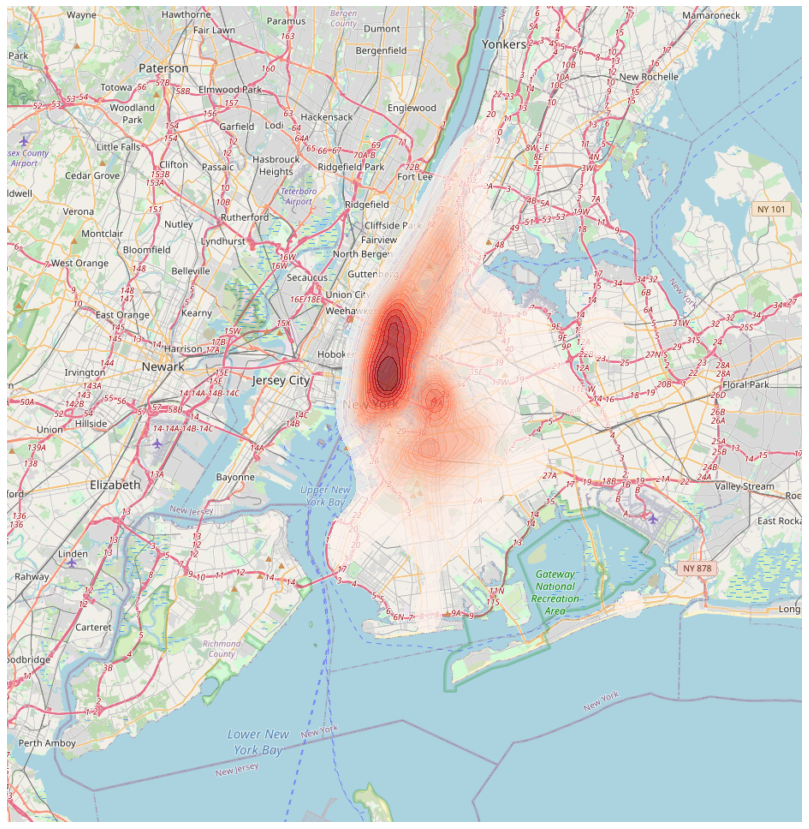

In [20]:
ax = gplt.webmap(boroughs, projection=gcrs.WebMercator(), figsize=(15,15))

gplt.kdeplot(
    rent_geo_df,
    weights=rent_geo_df.price,
    ax=ax, 
    cmap='Reds', 
    shade=True,
    n_levels=20,
    alpha=0.7
)

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.5`, but please update your code.
  warnings.warn(msg, UserWarning)


<GeoAxesSubplot:>

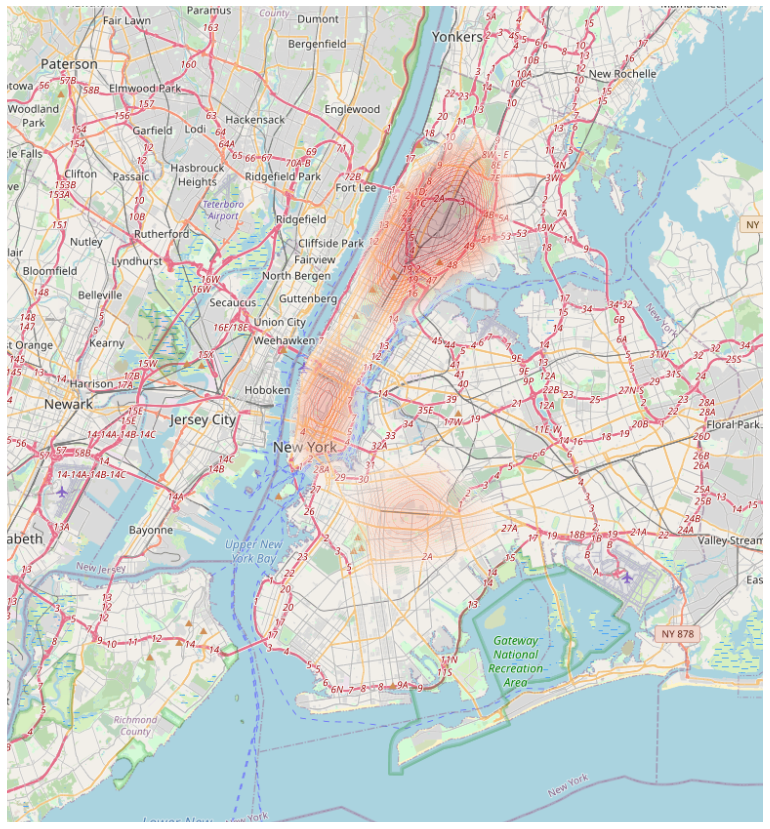

In [21]:
#robbery in 2020 heat map
ax = gplt.webmap(boroughs, projection=gcrs.WebMercator(),figsize=(15,15))
gplt.kdeplot(crime_geo_df[crime_geo_df.ofns_desc=='ROBBERY'], 
             ax=ax, 
             cmap='Reds', 
             shade=True,
             thresh=0.5,
             n_levels=30,
             alpha=0.25)

In [22]:
MANHATTAN_CENTER_COORDS = (40.741366, -73.987816)
HIGH_CRIME_COORDS = (40.833332, -73.902501)

In [23]:
def dist_from_point(df, point_coords):    
    return distance.distance(point_coords, (df.latitude, df.longitude)).km

In [24]:
df['dist_from_manh'] = df.apply(dist_from_point, axis = 1, args=(MANHATTAN_CENTER_COORDS,))
df['dist_from_crime'] = df.apply(dist_from_point, axis = 1, args=(HIGH_CRIME_COORDS,))

In [25]:
df['dist_from_crime']

0        21.464747
1        11.198317
2         4.282147
3        17.152175
4         5.215966
           ...    
48890    17.651419
48891    14.829920
48892     4.407638
48893    11.261973
48894    10.625639
Name: dist_from_crime, Length: 48895, dtype: float64

In [26]:
y = df.loc[:, df.columns == 'price']

In [27]:
y

price
0        149
1        225
2        150
3         89
4         80
...      ...
48890     70
48891     40
48892    115
48893     55
48894     90

[48895 rows x 1 columns]

In [28]:
#X = df.loc[:, df.columns != 'price']
X = df[['latitude', 'longitude', 'dist_from_manh', 'dist_from_crime']]

In [29]:
X

latitude  longitude  dist_from_manh  dist_from_crime
0      40.64749  -73.97237       10.506173        21.464747
1      40.75362  -73.98377        1.403042        11.198317
2      40.80902  -73.94190        8.453973         4.282147
3      40.68514  -73.95976        6.678721        17.152175
4      40.79851  -73.94399        7.345750         5.215966
...         ...        ...             ...              ...
48890  40.67853  -73.94995        7.676508        17.651419
48891  40.70184  -73.93317        6.370411        14.829920
48892  40.81475  -73.94867        8.793791         4.407638
48893  40.75751  -73.99112        1.814361        11.261973
48894  40.76404  -73.98933        2.521172        10.625639

[48895 rows x 4 columns]

In [36]:
clf.fit(X, y)
y_pred = clf.predict(X)

In [45]:
y_diff = y - y_pred

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

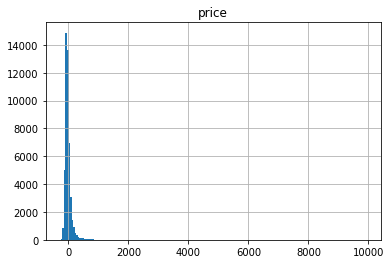

In [55]:
y_diff.hist(bins=200)

<GeoAxesSubplot:>

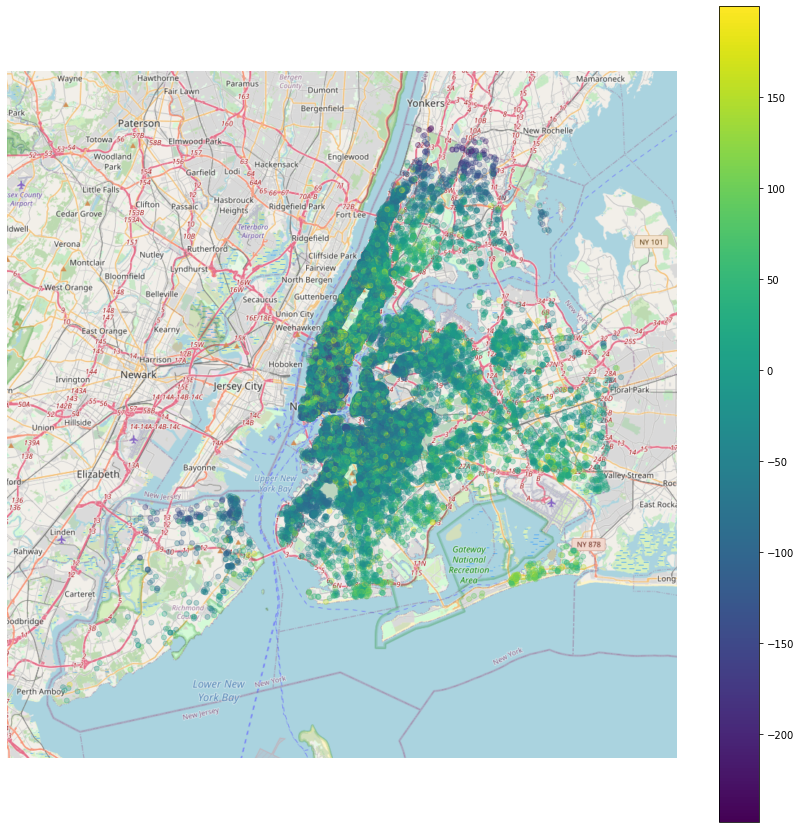

In [52]:
ax = gplt.webmap(boroughs, projection=gcrs.WebMercator(), figsize=(15,15))

gplt.pointplot(
    rent_geo_df[y_diff.price < 200],
    hue=y_diff[y_diff.price < 200].price,
    ax = ax,
    alpha=0.3,
    legend=True
)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [32]:
X_train.shape, X_test.shape

((34226, 4), (14669, 4))

In [33]:
clf = LinearRegression()

In [34]:
clf.fit(X_train, y_train)

LinearRegression()

In [35]:
y_pred = clf.predict(X_test)

In [23]:
diff = (y_test - y_pred) * (y_test - y_pred)

([array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([1., 0., 0., 0., 0., 0.

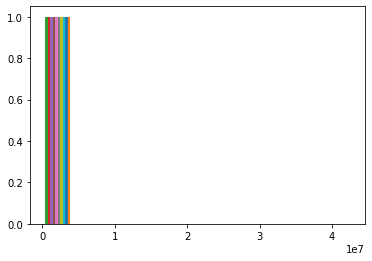

In [24]:
plt.hist(diff)